# Phase 3 Project
- author: Jonathan Holt
- Flatiron Data Science
- 7/19/21 Cohort

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_rows', 1000) #change the amount of rows displayed
plt.style.use('seaborn')

In [3]:
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Fixing column names

In [4]:
df.columns = df.columns.str.replace(' ','_')
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

# Inital Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   phone_number            3333 non-null   object 
 4   international_plan      3333 non-null   object 
 5   voice_mail_plan         3333 non-null   object 
 6   number_vmail_messages   3333 non-null   int64  
 7   total_day_minutes       3333 non-null   float64
 8   total_day_calls         3333 non-null   int64  
 9   total_day_charge        3333 non-null   float64
 10  total_eve_minutes       3333 non-null   float64
 11  total_eve_calls         3333 non-null   int64  
 12  total_eve_charge        3333 non-null   float64
 13  total_night_minutes     3333 non-null   float64
 14  total_night_calls       3333 non-null   

## 2/18/22

In [6]:
churned_df_base = df[df["churn"] == 1]
stayed_df_base = df[df["churn"] == 0]

In [7]:
churned_df_base.sort_values('total_day_minutes', ascending=False)

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
365,CO,154,415,343-5709,no,no,0,350.8,75,59.64,...,94,18.40,253.9,100,11.43,10.1,9,2.73,1,True
985,NY,64,415,345-9140,yes,no,0,346.8,55,58.96,...,79,21.21,275.4,102,12.39,13.3,9,3.59,1,True
2594,OH,115,510,348-1163,yes,no,0,345.3,81,58.70,...,106,17.29,217.5,107,9.79,11.8,8,3.19,1,True
156,OH,83,415,370-9116,no,no,0,337.4,120,57.36,...,116,19.33,153.9,114,6.93,15.8,7,4.27,0,True
605,MO,112,415,373-2053,no,no,0,335.5,77,57.04,...,109,18.06,265.0,132,11.93,12.7,8,3.43,2,True
975,DE,129,510,332-6181,no,no,0,334.3,118,56.83,...,104,16.33,191.0,83,8.59,10.4,6,2.81,0,True
15,NY,161,415,351-7269,no,no,0,332.9,67,56.59,...,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
1679,OK,82,510,393-4823,no,no,0,329.8,73,56.07,...,120,17.71,267.1,102,12.02,10.6,6,2.86,0,True
2028,SD,93,510,408-4836,no,no,0,328.1,106,55.78,...,89,12.89,303.5,114,13.66,8.7,3,2.35,1,True
197,TX,208,510,378-3625,no,no,0,326.5,67,55.51,...,113,14.99,181.7,102,8.18,10.7,6,2.89,2,True


In [8]:
#stayed_df_base['customer_service_calls'].value_counts()

In [9]:
#churned_df_base[.value_counts()

In [10]:
#df.describe()

In [11]:
#df.isna().sum()

In [12]:
#df.churn.value_counts()

In [13]:
#df['number_vmail_messages'].value_counts()

## Visualization of Class Imbalance

<AxesSubplot:xlabel='churn'>

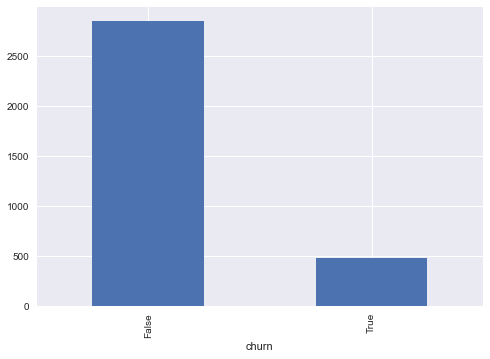

In [14]:
df.pivot_table(index='churn', aggfunc='size').plot(kind='bar')

# Cleaning and Preprocessing

In [15]:
#df.head()

In [16]:
test_df = df.copy()
test_df.head(2)

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


## Changing False to 0 and True to 1

In [17]:
test_df["churn"].value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [18]:
test_df["churn"] = test_df["churn"].astype(int)

In [19]:
test_df.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [20]:
#test_df = test_df.drop(columns=['state', 'phone_number', 'international_plan', 'voice_mail_plan'], axis=1)
test_df = test_df.drop(columns=['state','phone_number', 'area_code'], axis=1)

In [21]:
test_df.head(1)

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,0


## Total Charge

In [22]:
total_charge = test_df.apply(lambda x: x['total_day_charge'] + x['total_eve_charge'] +x['total_night_charge']
                             +x['total_intl_charge'], axis=1)
test_df['total_charge']= total_charge

## Slicing out object type Features

In [23]:
cont_features = [col for col in test_df.columns if test_df[col].dtype in [np.float64, np.int64]]

In [24]:
cont_features

['account_length',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'customer_service_calls',
 'churn',
 'total_charge']

In [25]:
feature_df = test_df.loc[:, cont_features]
#X_test_cat = X_test.loc[:, features_cat]
feature_df

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,75.56
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,59.24
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,62.29
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,66.80
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,52.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,0,60.10
3329,68,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,0,63.53
3330,28,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,0,67.74
3331,184,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,0,57.53


In [27]:
#need_to_encode = test_df[['area_code', 'customer_service_calls']]
need_to_encode = test_df[['international_plan', 'voice_mail_plan', 'customer_service_calls']]

In [ ]:
#IMPORTANT!
#Added 2/16 4PM. 
#feature_df = feature_df.drop(need_to_encode, axis=1)
#feature_df = feature_df.drop(['area_code', 'customer_service_calls'], axis=1)
#feature_df = feature_df.drop(['customer_service_calls'], axis=1)
#feature_df

## One Hot Encoding

In [28]:
ohe = OneHotEncoder()
ohe.fit(need_to_encode)

ohe_1 = ohe.transform(need_to_encode).toarray()

ohe_df = pd.DataFrame(ohe_1, columns=ohe.get_feature_names(need_to_encode.columns))
ohe_df.head()

,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dropping one value for categoricals

In [29]:
#IMPORTANT
#Dropping a few of the redundant values.
ohe_df = ohe_df.drop(['international_plan_no', 'voice_mail_plan_no'], axis=1)
ohe_df.head()

,international_plan_yes,voice_mail_plan_yes,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#cs_calls_1_2_3_df=ohe_df[['customer_service_calls_1', 'customer_service_calls_2',
#                          'customer_service_calls_3']]

In [ ]:
#cs_calls_1_2_3 = ohe_df.apply(lambda x: x['customer_service_calls_1'] + x['customer_service_calls_2']
#                              + x['customer_service_calls_3'], axis=1)
#cs_calls_4_5_6 = ohe_df.apply(lambda x: x['customer_service_calls_4'] + x['customer_service_calls_5']
#                              + x['customer_service_calls_6'], axis=1)
#cs_calls_7_8_9 = ohe_df.apply(lambda x: x['customer_service_calls_7'] + x['customer_service_calls_8']
#                              + x['customer_service_calls_9'], axis=1)

#ohe_df['cs_calls_1_2_3'] = cs_calls_1_2_3
#ohe_df['cs_calls_4_5_6'] = cs_calls_4_5_6
#ohe_df['cs_calls_7_8_9'] = cs_calls_7_8_9
#ohe_df.head()

In [30]:
cs_calls_low = ohe_df.apply(lambda x: x['customer_service_calls_0']+ x['customer_service_calls_1'] + x['customer_service_calls_2']
                              + x['customer_service_calls_3'], axis=1)
cs_calls_high= ohe_df.apply(lambda x: x['customer_service_calls_4'] + x['customer_service_calls_5']
                              + x['customer_service_calls_6'] + x['customer_service_calls_7']
                            + x['customer_service_calls_8']+ x['customer_service_calls_9'], axis=1)

ohe_df['cs_calls_low'] = cs_calls_low
ohe_df['cs_calls_high'] = cs_calls_high

In [31]:
ohe_df = ohe_df.drop(['customer_service_calls_1','customer_service_calls_2','customer_service_calls_3',
                     'customer_service_calls_4','customer_service_calls_5','customer_service_calls_6',
                     'customer_service_calls_7','customer_service_calls_8','customer_service_calls_9']
                    , axis=1)
ohe_df.head()

,international_plan_yes,voice_mail_plan_yes,customer_service_calls_0,cs_calls_low,cs_calls_high
0,0.0,1.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0


In [32]:
#2/22
#dropping cs_calls_low as it is redundant since this is now a binary choice.
ohe_df = ohe_df.drop(['cs_calls_low', 'customer_service_calls_0'], axis=1)

In [33]:
# Combining everything together

cleaned_df = pd.concat([pd.DataFrame(feature_df), ohe_df], axis=1)

In [34]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          3333 non-null   int64  
 1   number_vmail_messages   3333 non-null   int64  
 2   total_day_minutes       3333 non-null   float64
 3   total_day_calls         3333 non-null   int64  
 4   total_day_charge        3333 non-null   float64
 5   total_eve_minutes       3333 non-null   float64
 6   total_eve_calls         3333 non-null   int64  
 7   total_eve_charge        3333 non-null   float64
 8   total_night_minutes     3333 non-null   float64
 9   total_night_calls       3333 non-null   int64  
 10  total_night_charge      3333 non-null   float64
 11  total_intl_minutes      3333 non-null   float64
 12  total_intl_calls        3333 non-null   int64  
 13  total_intl_charge       3333 non-null   float64
 14  customer_service_calls  3333 non-null   

In [35]:
model_df = cleaned_df.copy()

In [ ]:
#model_df=model_df.drop([' 'customer_service_calls'], axis=1)

In [36]:
model_df=model_df.drop(['customer_service_calls','total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge']
                           , axis=1)

In [37]:
model_df.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,churn,total_charge,international_plan_yes,voice_mail_plan_yes,cs_calls_high
0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,0,75.56,0.0,1.0,0.0
1,107,26,161.6,123,195.5,103,254.4,103,13.7,3,0,59.24,0.0,1.0,0.0
2,137,0,243.4,114,121.2,110,162.6,104,12.2,5,0,62.29,0.0,0.0,0.0
3,84,0,299.4,71,61.9,88,196.9,89,6.6,7,0,66.80,1.0,0.0,0.0
4,75,0,166.7,113,148.3,122,186.9,121,10.1,3,0,52.09,1.0,0.0,0.0


In [ ]:
#2/22 4:30PM
#dropping all charge columns as they are likely correlated with minutes used
#if this proves to be true, find a way to plot and show the correlation
#model_df = model_df.drop(['total_day_charge', 'total_eve_charge', 'total_night_charge',
#                             'total_intl_charge'], axis=1)

In [ ]:
model_df.info()

In [ ]:
#Dropping the categories that are now duplicates
#model_df = model_df.drop(['churn', 'customer_service_calls'], axis=1)
#model_df.head()

In [39]:
#X = cleaned_df.drop(['churn'], axis=1)
X = model_df.drop(['churn'], axis=1)
#X = test_df[['area_code', 'international_plan', 'voice_mail_plan', 'customer_service_calls' ]]
#y = cleaned_df['churn']
y = model_df['churn']

# Initial Modeling (no SMOTE)

## Train-Test Split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=23)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=23)

In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2499 entries, 2486 to 512
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          2499 non-null   int64  
 1   number_vmail_messages   2499 non-null   int64  
 2   total_day_minutes       2499 non-null   float64
 3   total_day_calls         2499 non-null   int64  
 4   total_eve_minutes       2499 non-null   float64
 5   total_eve_calls         2499 non-null   int64  
 6   total_night_minutes     2499 non-null   float64
 7   total_night_calls       2499 non-null   int64  
 8   total_intl_minutes      2499 non-null   float64
 9   total_intl_calls        2499 non-null   int64  
 10  total_charge            2499 non-null   float64
 11  international_plan_yes  2499 non-null   float64
 12  voice_mail_plan_yes     2499 non-null   float64
 13  cs_calls_high           2499 non-null   float64
dtypes: float64(8), int64(6)
memory usage: 

## Decision Tree 1 (Baseline Decision Tree)

In [42]:
dtree_1 = DecisionTreeClassifier(random_state=23)

dtree_1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=23)

In [43]:
dt1_y_pred = dtree_1.predict(X_test)

### Evaluating Decision Tree 1

In [44]:
# Calculate Classification Metrics

dt1_acc = accuracy_score(y_test, dt1_y_pred) * 100
print('DTree 1 Accuracy is :{0}'.format(dt1_acc))
dt1_prec = precision_score(y_test, dt1_y_pred) * 100
print('DTree 1 Precision is :{0}'.format(dt1_prec))
dt1_rcl = recall_score(y_test, dt1_y_pred) * 100
print('DTree 1 Recall is :{0}'.format(dt1_rcl))
dt1_f1 = f1_score(y_test, dt1_y_pred) * 100
print('DTree 1 F1 Score is :{0}'.format(dt1_f1))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt1_y_pred)
dt1_roc_auc = auc(false_positive_rate, true_positive_rate)
print('DTree 1 AUC is :{0}'.format(round(dt1_roc_auc, 2)))
print('DTree 1 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, dt1_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

DTree 1 Accuracy is :94.48441247002398
DTree 1 Precision is :80.0
DTree 1 Recall is :82.64462809917356
DTree 1 F1 Score is :81.30081300813008
DTree 1 AUC is :0.9
DTree 1 Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,688,25,713
1,21,100,121
All,709,125,834


In [45]:
#dt1_acc = precision_score(y_test, dt1_y_pred) * 100
#print('DTree 1 Precision is :{0}'.format(dt1_acc))

In [46]:
# Check the AUC for predictions
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt1_y_pred)
#dt1_roc_auc = auc(false_positive_rate, true_positive_rate)
#print('\n DTree 1 AUC is :{0}'.format(round(dt1_roc_auc, 2)))

In [47]:
# Create and print a confusion matrix 
#print('\n DTree 1 Confusion Matrix')
#print('----------------')
#pd.crosstab(y_test, dt1_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

### Analysis of Accuracy, AUC, and Confusion Matrix
- Analysis goes HERE
- AND HERE
- AND HERE!

In [48]:
#dt1_cv_score = cross_val_score(dtree_1, X_train, y_train, cv=3)
#mean_dt1_cv_score = np.mean(dt1_cv_score)

#print(f"DTree 1 Mean Cross Validation Score: {mean_dt1_cv_score :.2%}")

## GridSearchCV & Decision Tree 2

In [49]:
#2/22 added class weight parameter
dtree_2 = DecisionTreeClassifier(random_state=23, class_weight="balanced")

In [50]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [51]:
# Instantiate GridSearchCV
#dt2_grid_search = GridSearchCV(dtree_2, dt_param_grid, cv=3, scoring = 'recall', return_train_score=True)
dt2_grid_search = GridSearchCV(dtree_2, dt_param_grid, cv=3, scoring = 'f1', return_train_score=True)

# Fit to the data
dt2_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=23),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, scoring='f1')

In [52]:
# Mean training score
dt2_gs_training_score = np.mean(dt2_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt2_gs_testing_score = dt2_grid_search.score(X_test, y_test)

print(f"DTree 2 Mean Training Score: {dt2_gs_training_score :.2%}")
print(f"DTree 2 Mean Test Score: {dt2_gs_testing_score :.2%}")
print("DTree 2 Best Parameter Combination Found During Grid Search:")
dt2_grid_search.best_params_

DTree 2 Mean Training Score: 82.57%
DTree 2 Mean Test Score: 90.67%
DTree 2 Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 10}

### Decision Tree 2

In [53]:
dtree_2 = DecisionTreeClassifier(criterion='entropy', 
                           max_depth=5,
                          min_samples_split=10,
                           min_samples_leaf=1,
                            random_state=23)

In [54]:
#dtree_2 = DecisionTreeClassifier(criterion='gini', 
#                           max_depth=3,
#                           min_samples_split=2,
#                           min_samples_leaf=1,
#                            random_state=23)

In [55]:
dtree_2.fit(X_train, y_train)
dt2_y_pred = dtree_2.predict(X_test)

### Evaluating Decision Tree 2

In [56]:
# Calculate Classification Metrics

dt2_acc = accuracy_score(y_test, dt2_y_pred) * 100
print('DTree 2 Accuracy is :{0}'.format(dt2_acc))
dt2_prec = precision_score(y_test, dt2_y_pred) * 100
print('DTree 2 Precision is :{0}'.format(dt2_prec))
dt2_rcl = recall_score(y_test, dt2_y_pred) * 100
print('DTree 2 Recall is :{0}'.format(dt2_rcl))
dt2_f1 = f1_score(y_test, dt1_y_pred) * 100
print('DTree 2 F1 Score is :{0}'.format(dt2_f1))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt2_y_pred)
dt2_roc_auc = auc(false_positive_rate, true_positive_rate)
print('DTree 2 AUC is :{0}'.format(round(dt2_roc_auc, 2)))
print('DTree 2 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, dt2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

DTree 2 Accuracy is :97.48201438848922
DTree 2 Precision is :100.0
DTree 2 Recall is :82.64462809917356
DTree 2 F1 Score is :81.30081300813008
DTree 2 AUC is :0.91
DTree 2 Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,713,0,713
1,21,100,121
All,734,100,834


In [57]:
# Calculate accuracy 
#dt2_acc = accuracy_score(y_test,dt2_y_pred) * 100
#print('DTree 2 Accuracy is :{0}'.format(dt2_acc))

# Check the AUC for predictions
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt2_y_pred)
#dt2_roc_auc = auc(false_positive_rate, true_positive_rate)
#print('DTree 2 AUC is :{0}'.format(round(dt2_roc_auc, 2)))

# Create and print a confusion matrix 
#print('DTree 2 Confusion Matrix')
#print('----------------')
#pd.crosstab(y_test, dt2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

### Analysis of Accuracy, AUC, and Confusion Matrix
- Analysis goes HERE
- AND HERE
- AND HERE!

## Random Forests 1

In [58]:
rf1_clf = RandomForestClassifier(random_state=23, class_weight="balanced")
mean_rf1_cv_score = np.mean(cross_val_score(rf1_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf1_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 96.92%


In [59]:
rf1_clf.fit(X_train, y_train)
rf1_y_pred = rf1_clf.predict(X_test)
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,rf1_y_pred)
#rf1_roc_auc = auc(false_positive_rate, true_positive_rate)
#rf1_roc_auc
#print(f"Random Forests 1 AUC Score: {rf1_roc_auc :.2%}")

### Evaluating Random Forests 1

In [60]:
# Calculate Classification Metrics

rf1_acc = accuracy_score(y_test, rf1_y_pred) * 100
print('Random Forests 1 Accuracy is :{0}'.format(rf1_acc))
rf1_prec = precision_score(y_test, rf1_y_pred) * 100
print('Random Forests 1 Precision is :{0}'.format(rf1_prec))
rf1_rcl = recall_score(y_test, rf1_y_pred) * 100
print('Random Forests 1 Recall is :{0}'.format(rf1_rcl))
rf1_f1 = f1_score(y_test, rf1_y_pred) * 100
print('Random Forests 1 F1 Score is :{0}'.format(rf1_f1))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf1_y_pred)
rf1_roc_auc = auc(false_positive_rate, true_positive_rate)
print('Random Forests 1 AUC is :{0}'.format(round(rf1_roc_auc, 2)))
print('Random Forests 1 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, rf1_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Random Forests 1 Accuracy is :96.76258992805755
Random Forests 1 Precision is :100.0
Random Forests 1 Recall is :77.68595041322314
Random Forests 1 F1 Score is :87.44186046511628
Random Forests 1 AUC is :0.89
Random Forests 1 Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,713,0,713
1,27,94,121
All,740,94,834


In [61]:
# Calculate accuracy 
#rf1_acc = accuracy_score(y_test,rf1_y_pred) * 100
#print('Random Forests 1 Accuracy is :{0}'.format(rf1_acc))

# Check the AUC for predictions
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf1_y_pred)
#rf1_roc_auc = auc(false_positive_rate, true_positive_rate)
#print('Random Forests 1 AUC is :{0}'.format(round(rf1_roc_auc, 2)))

# Create and print a confusion matrix 
#print('Random Forests Confusion Matrix')
#print('----------------')
#pd.crosstab(y_test, rf1_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

## GridSearch_CV & Random Forests 2

In [62]:
rf2_clf = RandomForestClassifier(random_state=23, class_weight="balanced")

In [63]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [64]:
#rf2_grid_search = GridSearchCV(rf2_clf, rf_param_grid, scoring = 'recall', cv=3)
rf2_grid_search = GridSearchCV(rf2_clf, rf_param_grid, scoring = 'f1', cv=3)
rf2_grid_search.fit(X_train, y_train)

print(f"Random Forest 2 Training Accuracy: {rf2_grid_search.best_score_ :.2%}")
print("")
# Mean test score
rf2_gs_testing_score = rf2_grid_search.score(X_test, y_test)
print("")
print(f"Random Forest 2 Optimal Parameters: {rf2_grid_search.best_params_}")

Random Forest 2 Training Accuracy: 90.75%


Random Forest 2 Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 100}


In [65]:
print(f"Random Forests 2 Mean Test Score: {rf2_gs_testing_score :.2%}")

Random Forests 2 Mean Test Score: 90.67%


In [66]:
rf2_clf = RandomForestClassifier(criterion= 'entropy',
                                max_depth= None,
                                min_samples_leaf= 6,
                                min_samples_split= 5,
                                n_estimators= 100)

mean_rf2_cv_score = np.mean(cross_val_score(rf2_clf, X_train, y_train, cv=3))

print(f"Random Forests 2 Mean Cross Validation Score: {mean_rf2_cv_score :.2%}")

Random Forests 2 Mean Cross Validation Score: 96.04%


In [67]:
#rf2_clf = RandomForestClassifier(criterion= 'gini',
#                                max_depth= None,
#                                min_samples_leaf= 3,
#                                min_samples_split= 5,
#                                n_estimators= 100)

#mean_rf2_cv_score = np.mean(cross_val_score(rf2_clf, X_train, y_train, cv=3))

#print(f"Random Forests 2 Mean Cross Validation Score: {mean_rf2_cv_score :.2%}")

In [68]:
rf2_clf.fit(X_train, y_train)
rf2_y_pred = rf2_clf.predict(X_test)
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,rf2_y_pred)
#rf2_roc_auc = auc(false_positive_rate, true_positive_rate)
#rf2_roc_auc
#print(f"Random Forests 2 AUC Score: {rf2_roc_auc :.2%}")

### Evaluating Random Forests 2

In [69]:
# Calculate Classification Metrics

rf2_acc = accuracy_score(y_test, rf2_y_pred) * 100
print('Random Forests 2 Accuracy is :{0}'.format(rf2_acc))
rf2_prec = precision_score(y_test, rf2_y_pred) * 100
print('Random Forests 2 Precision is :{0}'.format(rf2_prec))
rf2_rcl = recall_score(y_test, rf2_y_pred) * 100
print('Random Forests 2 Recall is :{0}'.format(rf2_rcl))
rf2_f1 = f1_score(y_test, rf2_y_pred) * 100
print('Random Forests 2 F1 Score is :{0}'.format(rf2_f1))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf2_y_pred)
rf2_roc_auc = auc(false_positive_rate, true_positive_rate)
print('Random Forests 2 AUC is :{0}'.format(round(rf2_roc_auc, 2)))
print('Random Forests 2 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, rf2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Random Forests 2 Accuracy is :97.3621103117506
Random Forests 2 Precision is :100.0
Random Forests 2 Recall is :81.81818181818183
Random Forests 2 F1 Score is :90.0
Random Forests 2 AUC is :0.91
Random Forests 2 Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,713,0,713
1,22,99,121
All,735,99,834


In [70]:
# Calculate accuracy 
#rf2_acc = accuracy_score(y_test,rf2_y_pred) * 100
#print('Random Forests 2 Accuracy is :{0}'.format(rf2_acc))

# Check the AUC for predictions
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf2_y_pred)
#rf2_roc_auc = auc(false_positive_rate, true_positive_rate)
#print('Random Forests 2 AUC is :{0}'.format(round(rf2_roc_auc, 2)))

# Create and print a confusion matrix 
#print('Random Forests 2 Confusion Matrix')
#print('----------------')
#pd.crosstab(y_test, rf2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [71]:
#dt2_score = dt2_grid_search.score(X_test, y_test)
#rf2_score = rf2_grid_search.score(X_test, y_test)

#print('Decision tree 2 grid search Score: ', dt2_score)
#print('Random forest 2 grid search Score: ', rf2_score)

# Modeling with Synthetic Samples (SMOTE)

In [112]:
balanced_df = model_df.copy()
balanced_df.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,churn,total_charge,international_plan_yes,voice_mail_plan_yes,cs_calls_high
0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,0,75.56,0.0,1.0,0.0
1,107,26,161.6,123,195.5,103,254.4,103,13.7,3,0,59.24,0.0,1.0,0.0
2,137,0,243.4,114,121.2,110,162.6,104,12.2,5,0,62.29,0.0,0.0,0.0
3,84,0,299.4,71,61.9,88,196.9,89,6.6,7,0,66.80,1.0,0.0,0.0
4,75,0,166.7,113,148.3,122,186.9,121,10.1,3,0,52.09,1.0,0.0,0.0


In [113]:
X = balanced_df.drop(['churn'], axis=1)
y = balanced_df['churn']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=23)

In [115]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

## Decision Tree 3

In [116]:
dtree_3 = DecisionTreeClassifier(random_state=23, class_weight="balanced")

dtree_3.fit(X_train_resampled, y_train_resampled)
dt3_y_pred = dtree_3.predict(X_test)

In [117]:
# Calculate Classification Metrics

dt3_acc = accuracy_score(y_test, dt3_y_pred) * 100
print('DTree 3 Accuracy is :{0}'.format(dt3_acc))
dt3_prec = precision_score(y_test, dt3_y_pred) * 100
print('DTree 3 Precision is :{0}'.format(dt3_prec))
dt3_rcl = recall_score(y_test, dt3_y_pred) * 100
print('DTree 3 Recall is :{0}'.format(dt3_rcl))
dt3_f1 = f1_score(y_test, dt3_y_pred) * 100
print('DTree 3 F1 Score is :{0}'.format(dt3_f1))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt3_y_pred)
dt3_roc_auc = auc(false_positive_rate, true_positive_rate)
print('DTree 3 AUC is :{0}'.format(round(dt3_roc_auc, 2)))
print('DTree 3 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, dt3_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

DTree 3 Accuracy is :93.28537170263789
DTree 3 Precision is :73.38129496402878
DTree 3 Recall is :84.29752066115702
DTree 3 F1 Score is :78.46153846153847
DTree 3 AUC is :0.9
DTree 3 Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,676,37,713
1,19,102,121
All,695,139,834


## GridSearchCV

In [118]:
dt3_grid_search = GridSearchCV(dtree_3, dt_param_grid, cv=3, scoring = 'f1', return_train_score=True)
# Fit to the data
dt3_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=23),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, scoring='f1')

In [119]:
# Mean training score
dt3_gs_training_score = np.mean(dt3_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt3_gs_testing_score = dt3_grid_search.score(X_test, y_test)

print(f"DTree 3 Mean Training Score: {dt3_gs_training_score :.2%}")
print(f"DTree 3 Mean Test Score: {dt3_gs_testing_score :.2%}")
print("DTree 3 Best Parameter Combination Found During Grid Search:")
dt3_grid_search.best_params_

DTree 3 Mean Training Score: 93.18%
DTree 3 Mean Test Score: 82.26%
DTree 3 Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

## Decision Tree 4

In [120]:
dtree_4 = DecisionTreeClassifier(criterion='entropy', 
                           max_depth=6,
                          min_samples_split=2,
                           min_samples_leaf=3,
                            random_state=23)

In [121]:
dtree_4.fit(X_train_resampled, y_train_resampled)
dt4_y_pred = dtree_4.predict(X_test)

In [122]:
# Calculate Classification Metrics

dt4_acc = accuracy_score(y_test, dt4_y_pred) * 100
print('DTree 4 Accuracy is :{0}'.format(dt4_acc))
dt4_prec = precision_score(y_test, dt3_y_pred) * 100
print('DTree 4 Precision is :{0}'.format(dt4_prec))
dt4_rcl = recall_score(y_test, dt4_y_pred) * 100
print('DTree 4 Recall is :{0}'.format(dt4_rcl))
dt4_f1 = f1_score(y_test, dt4_y_pred) * 100
print('DTree 4 F1 Score is :{0}'.format(dt4_f1))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt4_y_pred)
dt4_roc_auc = auc(false_positive_rate, true_positive_rate)
print('DTree 4 AUC is :{0}'.format(round(dt4_roc_auc, 2)))
print('DTree 4 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, dt4_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

DTree 4 Accuracy is :97.60191846522783
DTree 4 Precision is :73.38129496402878
DTree 4 Recall is :84.29752066115702
DTree 4 F1 Score is :91.07142857142858
DTree 4 AUC is :0.92
DTree 4 Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,712,1,713
1,19,102,121
All,731,103,834


## Random Forests 3

In [123]:
rf3_clf = RandomForestClassifier(random_state=23, class_weight="balanced")

In [124]:
#rf2_grid_search = GridSearchCV(rf2_clf, rf_param_grid, scoring = 'recall', cv=3)
rf3_grid_search = GridSearchCV(rf3_clf, rf_param_grid, scoring = 'f1', cv=3)
rf3_grid_search.fit(X_train_resampled, y_train_resampled)

print(f"Random Forest 3 Training Accuracy: {rf3_grid_search.best_score_ :.2%}")
print("")
# Mean test score
rf3_gs_testing_score = rf3_grid_search.score(X_test, y_test)
print("")
print(f"Random Forest 3 Optimal Parameters: {rf3_grid_search.best_params_}")

Random Forest 3 Training Accuracy: 97.12%


Random Forest 3 Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


In [125]:
rf3_clf = RandomForestClassifier(criterion= 'entropy',
                                max_depth= None,
                                min_samples_leaf= 3,
                                min_samples_split= 5,
                                n_estimators= 100)

mean_rf3_cv_score = np.mean(cross_val_score(rf3_clf, X_train_resampled, y_train_resampled, cv=3))

print(f"Random Forests 3 Mean Cross Validation Score: {mean_rf3_cv_score :.2%}")

Random Forests 3 Mean Cross Validation Score: 97.05%


In [126]:
rf3_clf.fit(X_train_resampled, y_train_resampled)
rf3_y_pred = rf3_clf.predict(X_test)

In [127]:
# Calculate Classification Metrics

rf3_acc = accuracy_score(y_test, rf3_y_pred) * 100
print('Random Forests 3 Accuracy is :{0}'.format(rf3_acc))
rf3_prec = precision_score(y_test, rf3_y_pred) * 100
print('Random Forests 3 Precision is :{0}'.format(rf3_prec))
rf3_rcl = recall_score(y_test, rf3_y_pred) * 100
print('Random Forests 3 Recall is :{0}'.format(rf3_rcl))
rf3_f1 = f1_score(y_test, rf3_y_pred) * 100
print('Random Forests 3 F1 Score is :{0}'.format(rf3_f1))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf3_y_pred)
rf3_roc_auc = auc(false_positive_rate, true_positive_rate)
print('Random Forests 3 AUC is :{0}'.format(round(rf3_roc_auc, 2)))
print(f"Random Forest 3 Training Accuracy: {rf3_grid_search.best_score_ :.2%}")
print(f"Random Forests 3 Mean Cross Validation Score: {mean_rf3_cv_score :.2%}")
print('Random Forests 3 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, rf3_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Random Forests 3 Accuracy is :97.3621103117506
Random Forests 3 Precision is :97.14285714285714
Random Forests 3 Recall is :84.29752066115702
Random Forests 3 F1 Score is :90.2654867256637
Random Forests 3 AUC is :0.92
Random Forest 3 Training Accuracy: 97.12%
Random Forests 3 Mean Cross Validation Score: 97.05%
Random Forests 3 Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,710,3,713
1,19,102,121
All,729,105,834


# Comparisons

In [128]:
#Recall
print('DTree 1 Recall is :{0}'.format(dt1_rcl))
print('DTree 2 Recall is :{0}'.format(dt2_rcl))
print('DTree 3 Recall is :{0}'.format(dt3_rcl))
print('DTree 4 Recall is :{0}'.format(dt4_rcl))
print('Random Forests 1 Recall is :{0}'.format(rf1_rcl))
print('Random Forests 2 Recall is :{0}'.format(rf2_rcl))
print('Random Forests 3 Recall is :{0}'.format(rf3_rcl))

DTree 1 Recall is :82.64462809917356
DTree 2 Recall is :82.64462809917356
DTree 3 Recall is :84.29752066115702
DTree 4 Recall is :84.29752066115702
Random Forests 1 Recall is :77.68595041322314
Random Forests 2 Recall is :81.81818181818183
Random Forests 3 Recall is :84.29752066115702


In [129]:
#Precision
print('DTree 1 Precision is :{0}'.format(dt1_prec))
print('DTree 2 Precision is :{0}'.format(dt2_prec))
print('DTree 3 Precision is :{0}'.format(dt3_prec))
print('DTree 4 Precision is :{0}'.format(dt4_prec))
print('Random Forests 1 Precision is :{0}'.format(rf1_prec))
print('Random Forests 2 Precision is :{0}'.format(rf2_prec))
print('Random Forests 3 Precision is :{0}'.format(rf3_prec))

DTree 1 Precision is :80.0
DTree 2 Precision is :100.0
DTree 3 Precision is :73.38129496402878
DTree 4 Precision is :73.38129496402878
Random Forests 1 Precision is :100.0
Random Forests 2 Precision is :100.0
Random Forests 3 Precision is :97.14285714285714


In [130]:
#F1 Score
print('DTree 1 F1 Score is :{0}'.format(dt1_f1))
print('DTree 2 F1 Score is :{0}'.format(dt2_f1))
print('DTree 3 F1 Score is :{0}'.format(dt3_f1))
print('DTree 4 F1 Score is :{0}'.format(dt4_f1))
print('Random Forests 1 F1 Score is :{0}'.format(rf1_f1))
print('Random Forests 2 F1 Score is :{0}'.format(rf2_f1))
print('Random Forests 3 F1 Score is :{0}'.format(rf3_f1))

DTree 1 F1 Score is :81.30081300813008
DTree 2 F1 Score is :81.30081300813008
DTree 3 F1 Score is :78.46153846153847
DTree 4 F1 Score is :91.07142857142858
Random Forests 1 F1 Score is :87.44186046511628
Random Forests 2 F1 Score is :90.0
Random Forests 3 F1 Score is :90.2654867256637


In [131]:
#ROC AUC
print('DTree 1 AUC is :{0}'.format(round(dt1_roc_auc, 2)))
print('DTree 2 AUC is :{0}'.format(round(dt2_roc_auc, 2)))
print('DTree 3 AUC is :{0}'.format(round(dt3_roc_auc, 2)))
print('DTree 4 AUC is :{0}'.format(round(dt4_roc_auc, 2)))
print('Random Forests 1 AUC is :{0}'.format(round(rf1_roc_auc, 2)))
print('Random Forests 2 AUC is :{0}'.format(round(rf2_roc_auc, 2)))
print('Random Forests 3 AUC is :{0}'.format(round(rf3_roc_auc, 2)))

DTree 1 AUC is :0.9
DTree 2 AUC is :0.91
DTree 3 AUC is :0.9
DTree 4 AUC is :0.92
Random Forests 1 AUC is :0.89
Random Forests 2 AUC is :0.91
Random Forests 3 AUC is :0.92


In [132]:
#Accuracy
print('DTree 1 Accuracy is :{0}'.format(dt1_acc))
print('DTree 2 Accuracy is :{0}'.format(dt2_acc))
print('DTree 3 Accuracy is :{0}'.format(dt3_acc))
print('DTree 4 Accuracy is :{0}'.format(dt4_acc))
print('Random Forests 1 Accuracy is :{0}'.format(rf1_acc))
print('Random Forests 2 Accuracy is :{0}'.format(rf2_acc))
print('Random Forests 3 Accuracy is :{0}'.format(rf3_acc))

DTree 1 Accuracy is :94.48441247002398
DTree 2 Accuracy is :97.48201438848922
DTree 3 Accuracy is :93.28537170263789
DTree 4 Accuracy is :97.60191846522783
Random Forests 1 Accuracy is :96.76258992805755
Random Forests 2 Accuracy is :97.3621103117506
Random Forests 3 Accuracy is :97.3621103117506


In [133]:
print('\n DTree 1 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, dt1_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('----------------')
print('----------------')
print('DTree 2 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, dt2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('----------------')
print('----------------')
print('DTree 3 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, dt3_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('----------------')
print('----------------')
print('DTree 4 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, dt4_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('----------------')
print('----------------')
print('Random Forests 1 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, rf1_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('----------------')
print('----------------')
print('Random Forests 2 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, rf2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('----------------')
print('----------------')
print('Random Forests 3 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, rf3_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))


 DTree 1 Confusion Matrix
----------------
Predicted    0    1  All
True                    
0          688   25  713
1           21  100  121
All        709  125  834
----------------
----------------
DTree 2 Confusion Matrix
----------------
Predicted    0    1  All
True                    
0          713    0  713
1           21  100  121
All        734  100  834
----------------
----------------
DTree 3 Confusion Matrix
----------------
Predicted    0    1  All
True                    
0          676   37  713
1           19  102  121
All        695  139  834
----------------
----------------
DTree 4 Confusion Matrix
----------------
Predicted    0    1  All
True                    
0          712    1  713
1           19  102  121
All        731  103  834
----------------
----------------
Random Forests 1 Confusion Matrix
----------------
Predicted    0   1  All
True                   
0          713   0  713
1           27  94  121
All        740  94  834
----------------
------

In [134]:
#Comparing the Tuned Models
print(f"DTree 2 Mean Training Score: {dt2_gs_training_score :.2%}")
print(f"DTree 2 Mean Test Score: {dt2_gs_testing_score :.2%}")
print('--------------------------------')
print(f"Random Forest 2 Training Accuracy: {rf2_grid_search.best_score_ :.2%}")
print(f"Random Forest 2 Mean Test Score: {rf2_gs_testing_score :.2%}")

DTree 2 Mean Training Score: 82.57%
DTree 2 Mean Test Score: 90.67%
--------------------------------
Random Forest 2 Training Accuracy: 90.75%
Random Forest 2 Mean Test Score: 90.67%


In [135]:
#print(f"DTree 1 Mean Cross Validation Score: {mean_dt1_cv_score :.2%}")
#print(f"DTree 1 Mean Training Score: {dt1_gs_training_score :.2%}")
#print(f"DTree 1 Mean Test Score: {dt1_gs_testing_score :.2%}")
#print('Decision tree 1 grid search Score: ', dt1_score)
#print(f"DTree 1 AUC Score: {dt1_roc_auc :.2%}")
print('--------------------------------')
#print(f"RandomForest 1 Mean Cross Validation Score: {mean_rf1_cv_score :.2%}")
#print(f"Random Forest 1 Training Accuracy: {rf1_grid_search.best_score_ :.2%}")
#print('Random forest 1 grid search Score: ', rf1_score)
#print(f"Random Forests 1 AUC Score: {rf1_roc_auc :.2%}")
print('--------------------------------')
#print(f"DTree 2 Mean Cross Validation Score: {mean_dt2_cv_score :.2%}")
print('--------------------------------')
#print(f"Random Forests 2 Mean Cross Validation Score: {mean_rf2_cv_score :.2%}")


--------------------------------
--------------------------------
--------------------------------


### Analysis:
    - Explain what cross validation score means
    - explain what training score means
    - explain what test score means
    - explain what grid search score means
    - explain what ROC AUC score means

## Optimal Parameters

In [136]:
#print("DTree 2 Best Parameter Combination Found During Grid Search:")
#dt2_grid_search.best_params_

In [137]:
print(f"Random Forest 1 Optimal Parameters: {rf2_grid_search.best_params_}")

Random Forest 1 Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 100}


# Feature Importance

## Currently set to analyze Random Forests 3

In [138]:
#final_model = 

In [139]:
feature_names = list(X)
feature_names

['account_length',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_eve_minutes',
 'total_eve_calls',
 'total_night_minutes',
 'total_night_calls',
 'total_intl_minutes',
 'total_intl_calls',
 'total_charge',
 'international_plan_yes',
 'voice_mail_plan_yes',
 'cs_calls_high']

In [140]:
rf3_importance = rf3_clf.feature_importances_
rf3_importance

array([0.0269471 , 0.03701472, 0.10731985, 0.02506145, 0.04376786,
       0.0231538 , 0.03357878, 0.02039985, 0.03550177, 0.03365671,
       0.23388791, 0.14526397, 0.04878602, 0.18566023])

In [141]:
#dt2_importance = dtree_2.feature_importances_
#dt2_importance

###  SORTED

In [142]:
#feature_importance_df = pd.DataFrame(rf2_importance, feature_names)
feature_importance_df = pd.DataFrame(rf3_importance, feature_names)
feature_importance_df= feature_importance_df.reset_index()
feature_importance_df.rename(columns={'index': 'Feature', 0: 'Importance'}, inplace=True)
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

,Feature,Importance
10,total_charge,0.233888
13,cs_calls_high,0.185660
11,international_plan_yes,0.145264
2,total_day_minutes,0.107320
12,voice_mail_plan_yes,0.048786
4,total_eve_minutes,0.043768
1,number_vmail_messages,0.037015
8,total_intl_minutes,0.035502
9,total_intl_calls,0.033657
6,total_night_minutes,0.033579


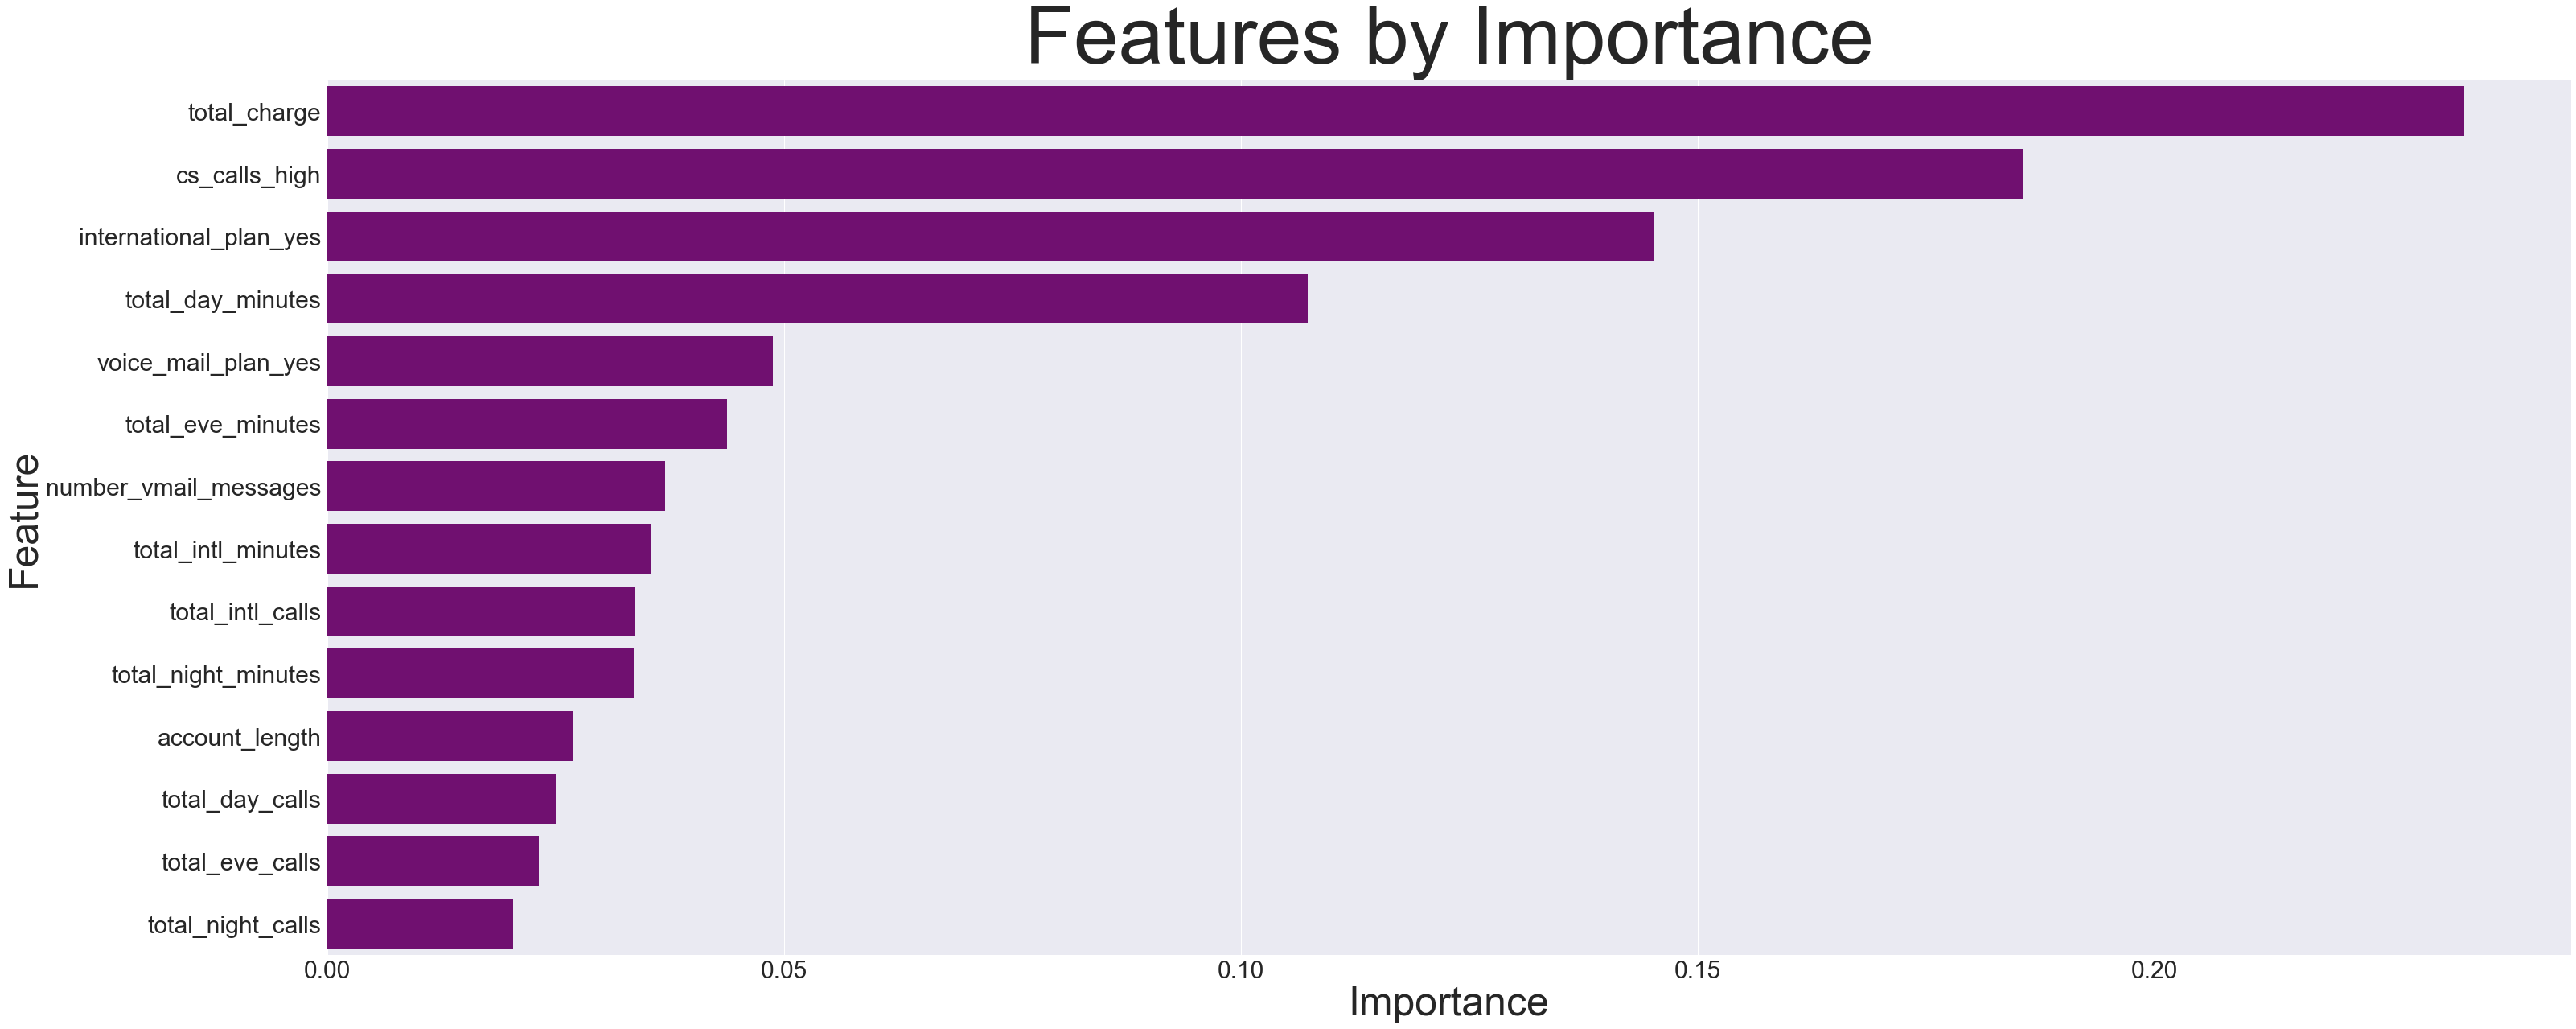

In [143]:
# plot feature importance
fig, ax = plt.subplots(figsize=(50,20))
#p = sns.barplot(data=feature_importance_df, x='Feature', y='Importance' );
p = sns.barplot(data=feature_importance_df, x='Importance', y='Feature', color='purple' );
p.set_xlabel("Importance", fontsize = 50)

p.set_ylabel("Feature", fontsize = 50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#p.yaxis.set_major_formatter(display_millions)
p.set_title("Features by Importance", fontsize = 100)
plt.figsize=(30,20) 
#plt.savefig('images/project_1_bar_3')

plt.show();

In [144]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          3333 non-null   int64  
 1   number_vmail_messages   3333 non-null   int64  
 2   total_day_minutes       3333 non-null   float64
 3   total_day_calls         3333 non-null   int64  
 4   total_eve_minutes       3333 non-null   float64
 5   total_eve_calls         3333 non-null   int64  
 6   total_night_minutes     3333 non-null   float64
 7   total_night_calls       3333 non-null   int64  
 8   total_intl_minutes      3333 non-null   float64
 9   total_intl_calls        3333 non-null   int64  
 10  total_charge            3333 non-null   float64
 11  international_plan_yes  3333 non-null   float64
 12  voice_mail_plan_yes     3333 non-null   float64
 13  cs_calls_high           3333 non-null   float64
dtypes: float64(8), int64(6)
memory usage: 36

## Analysis
- Figure out how to rank feature importance as this is the ultimate outcome for my business problem.
- VISUALIZE!!!!

# Analysis of Churned Customer Key Categories

New as of 2/22 5PM

In [148]:
analysis_df = cleaned_df.copy()
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          3333 non-null   int64  
 1   number_vmail_messages   3333 non-null   int64  
 2   total_day_minutes       3333 non-null   float64
 3   total_day_calls         3333 non-null   int64  
 4   total_day_charge        3333 non-null   float64
 5   total_eve_minutes       3333 non-null   float64
 6   total_eve_calls         3333 non-null   int64  
 7   total_eve_charge        3333 non-null   float64
 8   total_night_minutes     3333 non-null   float64
 9   total_night_calls       3333 non-null   int64  
 10  total_night_charge      3333 non-null   float64
 11  total_intl_minutes      3333 non-null   float64
 12  total_intl_calls        3333 non-null   int64  
 13  total_intl_charge       3333 non-null   float64
 14  customer_service_calls  3333 non-null   

In [149]:
#analysis_df = cleaned_df[['total_day_calls','total_day_minutes', 'total_eve_calls',
#                          'total_eve_minutes', 'international_plan_yes', 'total_intl_calls', 'total_charge',
#                          'churn']]

In [ ]:
analysis_df.sort_values('total_day_minutes', ascending=False).head(999)

In [ ]:
#churned_df = analysis_df[analysis_df["churn_1"] == 1]
#churned_df

## Customer Service Calls vs. Churn

In [168]:
cs_churn_df = analysis_df.groupby('customer_service_calls')['churn'].sum().reset_index()

In [169]:
cs_churn_df

,customer_service_calls,churn
0,0,92
1,1,122
2,2,87
3,3,44
4,4,76
5,5,40
6,6,14
7,7,5
8,8,1
9,9,2


In [170]:
cs_churn_df = cs_churn_df.rename(columns={"customer_service_calls": "#_of_calls"})

In [171]:
cs_churn_df

,#_of_calls,churn
0,0,92
1,1,122
2,2,87
3,3,44
4,4,76
5,5,40
6,6,14
7,7,5
8,8,1
9,9,2


In [155]:
variable_1 = analysis_df['customer_service_calls'].value_counts().reset_index()

In [157]:
analysis_df['customer_service_calls'].value_counts()

1    1181
2     759
0     697
3     429
4     166
5      66
6      22
7       9
9       2
8       2
Name: customer_service_calls, dtype: int64

In [158]:
variable_1 = variable_1.rename(columns={"index": "#_of_calls", "customer_service_calls": "#_of_accounts"})

In [174]:
variable_1

,#_of_calls,#_of_accounts
0,1,1181
1,2,759
2,0,697
3,3,429
4,4,166
5,5,66
6,6,22
7,7,9
8,9,2
9,8,2


In [177]:
cs_churn_df = cs_churn_df.merge(variable_1, on='#_of_calls')
cs_churn_df

,#_of_calls,churn,#_of_accounts
0,0,92,697
1,1,122,1181
2,2,87,759
3,3,44,429
4,4,76,166
5,5,40,66
6,6,14,22
7,7,5,9
8,8,1,2
9,9,2,2


In [179]:
churn_rate = cs_churn_df.apply(lambda x: x['churn'] / x['#_of_accounts'], axis=1)
cs_churn_df['churn_rate']= churn_rate

In [180]:
cs_churn_df

,#_of_calls,churn,#_of_accounts,churn_rate
0,0,92,697,0.131994
1,1,122,1181,0.103302
2,2,87,759,0.114625
3,3,44,429,0.102564
4,4,76,166,0.457831
5,5,40,66,0.606061
6,6,14,22,0.636364
7,7,5,9,0.555556
8,8,1,2,0.500000
9,9,2,2,1.000000


# Visualization: Customer Service Call Churn Rate 

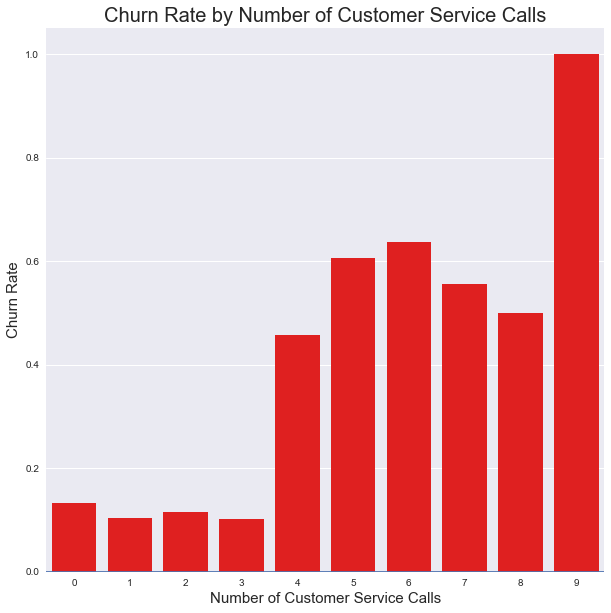

In [186]:
fig, ax = plt.subplots(figsize=(10,10))
p = sns.barplot(x="#_of_calls", y="churn_rate", data=cs_churn_df, color='red');

p.set_xlabel("Number of Customer Service Calls", fontsize = 15)
p.set_ylabel("Churn Rate", fontsize = 15)
#p.xaxis.set_major_formatter(display_millions)
p.set_title("Churn Rate by Number of Customer Service Calls", fontsize = 20)
plt.figsize=(30,20) 
plt.axhline(y=0)
#plt.savefig('images/project_1_scatter_1')

plt.show();

## Analysis of Day Minutes

In [ ]:
analysis_df['total_day_minutes'].describe()

In [ ]:
high_day_minutes_df = analysis_df[analysis_df["total_day_minutes"] >= 250]
low_day_minutes_df = analysis_df[analysis_df["total_day_minutes"] < 250]

In [ ]:
high_day_minutes_df['churn_1'].value_counts()

In [ ]:
low_day_minutes_df['churn_1'].value_counts()

In [ ]:
#analysis_df.sort_values('total_day_charge', ascending=False)

In [ ]:
high_day_minutes_df.sort_values('total_day_minutes', ascending=True)

### Day Minute Analysis
Churn rate is nearly 50% when day minutes are 250 or more.

In [ ]:
#analysis_df_2 = analysis_df.groupby('churn_1')['total_day_calls'].describe().sort_values('mean', ascending=False)
#analysis_df_2

## International Plan

In [ ]:
intl_df = analysis_df.copy()

In [ ]:
intl_df = intl_df[intl_df["international_plan_yes"] == 1]

In [ ]:
intl_df['churn_1'].value_counts()

In [ ]:
intl_df['total_charge'].describe()

### Analysis
42% of customers with an international plan leave.

## Total Charge

In [ ]:
analysis_df['total_charge'].describe()

In [ ]:
high_charge_df = analysis_df[analysis_df["total_charge"] >= 67]
low_charge_df = analysis_df[analysis_df["total_charge"] < 67]

In [ ]:
high_charge_df['churn_1'].value_counts()

High Charge = 30.8% Churn

In [ ]:
low_charge_df['churn_1'].value_counts()

In [ ]:
analysis_df.groupby(['churn_1']).describe()

In [ ]:
analysis_df['total_charge'].describe()

In [ ]:
analysis_df['charge_group'] = pd.qcut(analysis_df['total_charge'], 10)

In [ ]:
new_df = analysis_df.groupby('charge_group')['churn_1'].sum().reset_index()

In [ ]:
new_df['total_count'] = new_df_2['']

In [ ]:
new_df_2 = analysis_df['charge_group'].value_counts().reset_index()

In [ ]:
new_df = pd.concat([pd.DataFrame(new_df), new_df_2], axis=1)

In [ ]:
new_df.drop(['total_count'])

In [ ]:
analysis_df['charge_group']['churn_1'].sum()

Low Charge = 9.5% churn

# Visualizations

In [ ]:
sns.scatterplot(data=analysis_df['total_charge'])

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
p = sns.scatterplot(x="total_charge", y="ROI", data=analysis_df);

p.set_xlabel("Budget", fontsize = 15)
p.set_ylabel("ROI", fontsize = 15)
p.xaxis.set_major_formatter(display_millions)
p.set_title("Distribution of Recent Animated and Adventure Movies by Budget", fontsize = 20)
plt.figsize=(30,20) 
plt.axhline(y=0)
plt.savefig('images/project_1_scatter_1')

plt.show();

# Archive

## Analysis of Churned Customers (Old)

In [ ]:
cleaned_df

In [ ]:
churned_df = cleaned_df[cleaned_df["churn_1"] == 1]
churned_df

In [ ]:
churned_df.info()

In [ ]:
churn_means = churned_df.mean()

In [ ]:
stayed_df = cleaned_df[cleaned_df["churn_1"] == 0]
stayed_df

In [ ]:
stayed_means = stayed_df.mean()

In [ ]:
stayed_means = stayed_means.reset_index()

In [ ]:
stayed_means = stayed_means.rename(columns={0: "Stayed"})

In [ ]:
stayed_means

In [ ]:
churn_means = churn_means.reset_index()

In [ ]:
churn_means = churn_means.rename(columns={0: "Left"})

In [ ]:
new_df = pd.merge(stayed_means, churn_means, on= 'index')
new_df.head()

In [ ]:
#new_df = new_df.drop(columns=['level_0_x', 'level_0_y'], axis=1)
#new_df.head()

In [ ]:
new_df['Delta']= new_df.apply(lambda x: x['Left'] - x['Stayed'], axis=1)

In [ ]:
new_df

In [ ]:
#churned_df.sort_values('cs_calls_4_5_6', ascending=False)

In [ ]:
churned_df.info()

In [ ]:
churned_df_cat = churned_df[['cs_calls_high','voice_mail_plan_yes', 'international_plan_yes']]
churned_df_cat


In [ ]:
churned_df_cat.sum()

In [ ]:
stayed_df_cat = stayed_df[['cs_calls_high','voice_mail_plan_yes', 'international_plan_yes']]
stayed_df_cat

In [ ]:
stayed_df_cat.sum()

In [ ]:
churned_df.info()

In [ ]:
churned_df_num = churned_df[['account_length', "number_vmail_messages", "total_day_calls", "total_eve_calls",
                             "total_night_minutes", "total_night_calls", "total_intl_calls",
                             "total_intl_minutes",]]

In [ ]:
#churned_df_num = churned_df[['account_length', "number_vmail_messages", "total_day_calls", "total_day_charge",
#                             "total_eve_calls", "total_eve_charge", "total_night_minutes", "total_night_calls",
#                             "total_night_charge", "total_intl_calls", "total_intl_minutes", "total_intl_charge"
#                            ]]

In [ ]:
stayed_df_num = stayed_df[['account_length', "number_vmail_messages", "total_day_calls", "total_eve_calls",
                             "total_night_minutes", "total_night_calls", "total_intl_calls",
                             "total_intl_minutes",]]

In [ ]:
#stayed_df_num = stayed_df[['account_length', "number_vmail_messages", "total_day_calls", "total_day_charge",
#                             "total_eve_calls", "total_eve_charge", "total_night_minutes", "total_night_calls",
#                             "total_night_charge", "total_intl_calls", "total_intl_minutes", "total_intl_charge"
#                            ]]

In [ ]:
churned_df_num.mean()

In [ ]:
churned_df_num.describe()

In [ ]:
stayed_df_num.mean()

In [ ]:
churned_df_num['total_day_charge'].value_counts()